In [1]:
### basic libraries
import os
from json import dumps
import pandas as pd 
import numpy as np

### carto libraries
import shapefile ### not necessary ?
import geopandas as gp
#from shapely.geometry import Polygon
from shapely.geometry import shape

### for plotting in Jupyter
%matplotlib inline
import matplotlib.pyplot as plt
#import seaborn as sns
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (10.0, 10.0)

from app.scripts.topojson import topojson

from pyproj import Proj, transform ### not necessary ?

crs_lambert93 = 2154
crs_WSG84     = 4326
inCRS  = 'epsg:%s' %(crs_lambert93)
outCRS = 'epsg:%s' %(crs_WSG84)
inProj  = Proj(init=inCRS)  # proj in  : Lambert 93
outProj = Proj(init=outCRS) # proj out : WSG 84

### TO DO : find topojson libraries to reduce output file size


In [2]:
### basic folders addresses and names
cwd = os.getcwd()

data_folder = "app/static/data"
carto_folder = "carto"

carto_path = os.path.join(cwd, data_folder, carto_folder)

print "-- cwd :"        , cwd
print "-- carto path : ", carto_path


-- cwd : /Users/jpy/Dropbox/_FLASK/concours_pesticides
-- carto path :  /Users/jpy/Dropbox/_FLASK/concours_pesticides/app/static/data/carto


In [3]:
### basic pandas tools

idx = pd.IndexSlice

def checkDTypes (df) :
    # check data type
    
    for index in df.index.names :
        print "---- index : ", index

    for col in df.columns :
        #label = col.values
        dtype = df[col].dtype
        
        print "---- dtypes col : ", col, "/", dtype
        

In [4]:
# cf : https://pypi.python.org/pypi/pyshp
# cf : http://gis.stackexchange.com/questions/183795/how-do-i-select-shapefiles-to-be-converted-to-geojson-in-folder-with-multiple-sh
# cf : https://github.com/mlaloux/Python-geo_interface-applications/blob/master/PyShp_geointerface.py

# cf : https://glenbambrick.com/tag/pyshp/
# cf : https://glenbambrick.com/2016/01/24/reproject-shapefile/

In [5]:
### reading/writing - converting shp files to geojson
    
def geofile_path(filename, extension):
    path = os.path.join(carto_path , filename + extension )
    print "-- file path : ", path
    return path


In [6]:
### SHP and GEOJSON files 
_shp     = ".shp"
_json    = ".json"
_geojson = ".geojson"
_copy    = "_copy"

water_shp_fname    = "PolygMasseDEauSouterraine"


## add departements .geojson for other future datas than water (f.i. agriculture stats / src : Etalab)
# https://github.com/gregoiredavid/france-geojson

admin_regions      = "regions"
admin_regions_2015 = "regions_2015"
admin_departements = "departements"
admin_communes     = "communes"


In [7]:
### DEPRECATED : read .shp with shapefile
'''
def readSHP(filename):  
    # generator 
    reader = shapefile.Reader( root_carto_folder+ filename + _shp )  
    fields = reader.fields[1:]  
    field_names = [field[0] for field in fields]  
    for sr in reader.shapeRecords():  
        geom = sr.shape.__geo_interface__  
        atr = dict(zip(field_names, sr.record))  
        yield dict(geometry=geom,properties=atr)    
'''

def readSHP(filename) :
    
    # read the shapefile
    reader = shapefile.Reader( geofile_path( water_shp_fname, _shp ) )
    fields = reader.fields[1:]
    field_names = [field[0] for field in fields]

    buffer = []
    for sr in reader.shapeRecords():
       atr = dict(zip(field_names, sr.record))
       geom = sr.shape.__geo_interface__
       buffer.append(dict(type="Feature", geometry=geom, properties=atr)) 

    # write the GeoJSON file (copy)
    geojson = open( os.path.join( carto_path, filename + _copy + _json), "w")
    geojson.write(dumps({"type": "FeatureCollection", "features": buffer}, indent=2) + "\n")
    geojson.close()
    

In [8]:
### options for gdf.read_file()
#import fiona; help(fiona.open)

### options for gdf.to_file()
#import fiona; fiona.supported_drivers

In [9]:
### read departements / regions geojson with geopandas

#gdf_dpts = gp.GeoDataFrame.from_file( geofile_path( admin_departements, _geojson ) )
gdf_dpts         = gp.read_file( geofile_path( admin_departements, _geojson ) )
gdf_regions      = gp.read_file( geofile_path( admin_regions, _geojson ) )
gdf_regions_2015 = gp.read_file( geofile_path( admin_regions_2015, _geojson ) )

print gdf_dpts.crs

# change projection crs (greedy)
# http://geopandas.org/projections.html

#gdf_dpts = gdf_dpts.to_crs(epsg=crs_WSG84)
#gdf_dpts = gdf_dpts.to_crs({'init': 'epsg:%s' %(crs_lambert93)} )
gdf_dpts         = gdf_dpts.to_crs(epsg=crs_lambert93)
gdf_regions      = gdf_regions.to_crs(epsg=crs_lambert93)
gdf_regions_2015 = gdf_regions_2015.to_crs(epsg=crs_lambert93)

print gdf_dpts.crs



-- file path :  /Users/jpy/Dropbox/_FLASK/concours_pesticides/app/static/data/carto/departements.geojson
-- file path :  /Users/jpy/Dropbox/_FLASK/concours_pesticides/app/static/data/carto/regions.geojson
-- file path :  /Users/jpy/Dropbox/_FLASK/concours_pesticides/app/static/data/carto/regions_2015.geojson
{'init': u'epsg:4326'}
{'init': 'epsg:2154', 'no_defs': True}


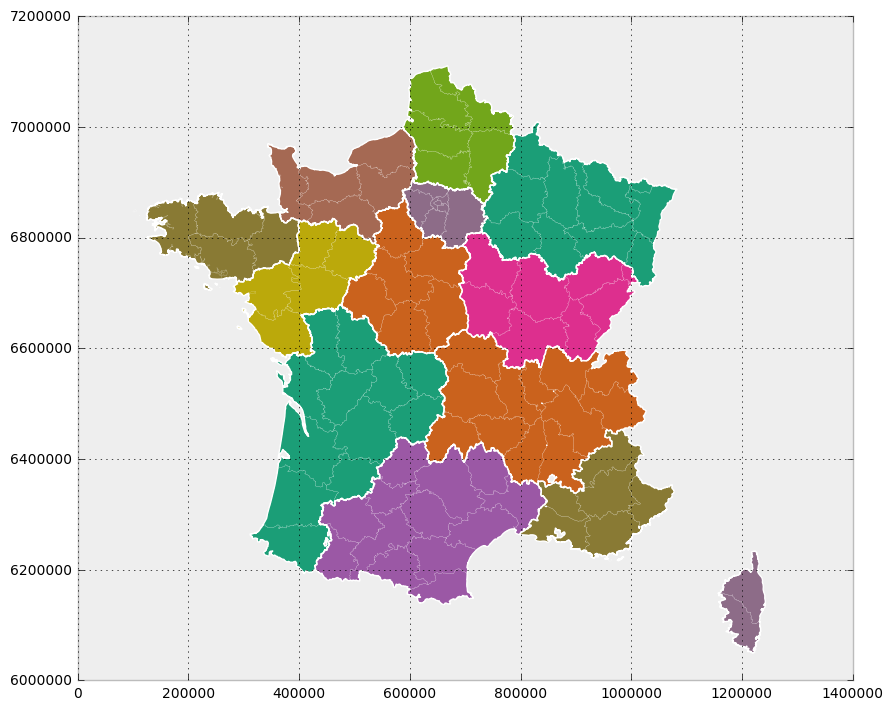

In [41]:
'''
Colormap White is not recognized. Possible values are: 
Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, 
CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, 
Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, 
PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, 
RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, 
Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, 
YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, 
binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cool, cool_r, coolwarm, coolwarm_r, copper, 
copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, 
gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, 
gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, 
hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, 
nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, 
rainbow_r, seismic, seismic_r, spectral, spectral_r, spring, spring_r, summer, summer_r, 
terrain, terrain_r, viridis, viridis_r, winter, winter_r
'''

cmaps = [('Perceptually Uniform Sequential',
                            ['viridis', 'inferno', 'plasma', 'magma']),
         ('Sequential',     ['Blues', 'BuGn', 'BuPu',
                             'GnBu', 'Greens', 'Greys', 'Oranges', 'OrRd',
                             'PuBu', 'PuBuGn', 'PuRd', 'Purples', 'RdPu',
                             'Reds', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd']),
         ('Sequential (2)', ['afmhot', 'autumn', 'bone', 'cool',
                             'copper', 'gist_heat', 'gray', 'hot',
                             'pink', 'spring', 'summer', 'winter']),
         ('Diverging',      ['BrBG', 'bwr', 'coolwarm', 'PiYG', 'PRGn', 'PuOr',
                             'RdBu', 'RdGy', 'RdYlBu', 'RdYlGn', 'Spectral',
                             'seismic']),
         ('Qualitative',    ['Accent', 'Dark2', 'Paired', 'Pastel1',
                             'Pastel2', 'Set1', 'Set2', 'Set3']),
         ('Miscellaneous',  ['gist_earth', 'terrain', 'ocean', 'gist_stern',
                             'brg', 'CMRmap', 'cubehelix',
                             'gnuplot', 'gnuplot2', 'gist_ncar',
                             'nipy_spectral', 'jet', 'rainbow',
                             'gist_rainbow', 'hsv', 'flag', 'prism'])]


# cf : https://gist.github.com/jakevdp/91077b0cae40f8f8244a   
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


#plot_reg        = gdf_regions.plot(cmap=discrete_cmap(13, "Dark2"), alpha=1, edgecolor='White' )
plot_reg_2015   = gdf_regions_2015.plot(cmap=discrete_cmap(13, "Dark2"), alpha=1, edgecolor='White' )
plot_dpt        = gdf_dpts.plot(ax=plot_reg_2015, cmap=None, alpha=0, edgecolor='White', linewidth='0.1')


In [11]:
### read .shp waters with geopandas (greedy)

shp_encoding = "utf-8" ### doesnt work
shp_encoding = "latin-1" ### not sure

crs_source = crs_lambert93
#crs_source = "lcc" ### not sure
## {'proj': 'longlat', 'ellps': 'WGS84', 'datum': 'WGS84','no_defs': True}


# read file
#gdf_waters = gp.read_file( geofile_path( water_shp_fname, _shp ), crs=crs_source, encoding=shp_encoding )
gdf_waters = gp.GeoDataFrame.from_file( geofile_path( water_shp_fname, _shp ) )

# set and sort index
gdf_waters.set_index(["CdBassinDC", "CdMasseDEa"], inplace=True)
gdf_waters.sortlevel(inplace=True) 


-- file path :  /Users/jpy/Dropbox/_FLASK/concours_pesticides/app/static/data/carto/PolygMasseDEauSouterraine.shp


In [12]:
print gdf_waters.shape

(1103, 24)


In [13]:
gdf_waters.info(memory_usage="deep")

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 1103 entries, (A, AG001) to (H, HG508)
Data columns (total 24 columns):
CdEcoregio    1103 non-null object
CdEuMasseD    1103 non-null object
CdPolygMas    1103 non-null object
Commentair    551 non-null object
DateCreati    1103 non-null object
DateMajMas    1103 non-null object
FrangeLitt    1103 non-null object
Karstique     1103 non-null object
LatMasseDE    1103 non-null float64
LonMasseDE    1103 non-null float64
MasseDEauA    1103 non-null object
MasseDEauT    1103 non-null object
NatureEcou    1103 non-null object
Niveau        1103 non-null int64
NomMasseDE    1103 non-null object
PrecSupMas    1103 non-null object
Regroupees    1103 non-null object
StMasseDEa    1103 non-null object
SurfaceAff    1103 non-null float64
SurfaceSsC    1103 non-null float64
SurfaceTot    1103 non-null float64
SystemeRef    1103 non-null object
TypeMasseD    1103 non-null object
geometry      1103 non-null object
dtypes: float64(5), int64(1

In [14]:
gdf_waters.memory_usage().sum()

220043

In [15]:
gdf_waters["area"] = gdf_waters["geometry"].area

In [16]:
test_geom = gdf_waters.loc["A","AG001"]["geometry"]
print test_geom.area

CdBassinDC  CdMasseDEa
A           AG001         8.237526e+07
            AG001         8.681770e+08
dtype: float64


In [17]:
#checkDTypes(gdf_waters) 


In [18]:
slice_gdf = idx[ "A" , : ]
gdf_waters.loc[ slice_gdf , : ]["geometry"]


CdBassinDC  CdMasseDEa
A           AG001         POLYGON ((651859.6700888127 7067573.305585384,...
            AG001         (POLYGON ((617227.0852775276 7096815.711801797...
            AG002         POLYGON ((617970.4125330001 7063544.312811732,...
            AG003         (POLYGON ((719164.1102770045 7051492.354207844...
            AG003         POLYGON ((704207.8221555278 7065745.600930788,...
            AG004         POLYGON ((684632.2949341163 7062565.239111453,...
            AG004         POLYGON ((679511.3547973856 7047680.745381318,...
            AG005         POLYGON ((617970.4125330001 7063544.312811732,...
            AG006         POLYGON ((720018.0545961335 7051803.254542559,...
            AG006         POLYGON ((734546.9334979951 7030122.194827668,...
            AG007         POLYGON ((747937.639777258 7034879.219169378, ...
            AG007         POLYGON ((747937.639777258 7034879.219169378, ...
            AG008         POLYGON ((662617.6466776133 7031850.106

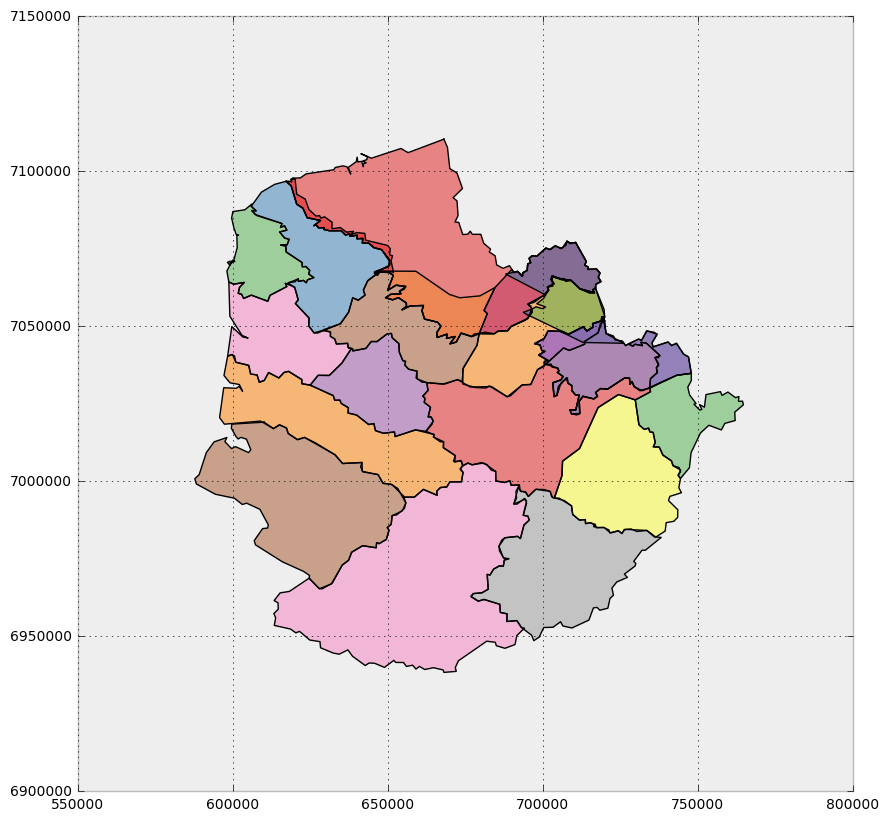

In [19]:
#gdf.head(10).plot()
#gdf.loc["A", "AG015"]["geometry"].simplify(200, preserve_topology=False).plot()
#gdf.loc["B1"]["geometry"].simplify(500, preserve_topology=False).plot()
#gdf.loc["A":"B1"]["geometry"].simplify(700, preserve_topology=False).plot()
gdf_waters.loc[ slice_gdf, :  ]["geometry"].simplify(500, preserve_topology=False).plot()


In [20]:
# test extract and copy

#gdf_waters_test_union = gp.GeoDataFrame( data=gdf_waters.loc["A","AG001"].head(1), index=gdf_waters.index, columns=gdf_waters.columns)
gdf_waters_test_union = gp.GeoDataFrame( data=gdf_waters.loc[ slice_gdf, : ].head(1), index=None, columns=gdf_waters.columns)
gdf_waters_test_union


,,CdEcoregio,CdEuMasseD,CdPolygMas,Commentair,DateCreati,DateMajMas,FrangeLitt,Karstique,LatMasseDE,LonMasseDE,...,PrecSupMas,Regroupees,StMasseDEa,SurfaceAff,SurfaceSsC,SurfaceTot,SystemeRef,TypeMasseD,geometry,area
CdBassinDC,CdMasseDEa,,,,,,,,,,,,,,,,,,,,,
A,AG001,13,FRAG001,00000002,None,31/12/2004,18/12/2013,N,N,7.069081e+06,639573.042158,...,1,N,ValidÃ©,868.2,82.4,950.6,26,DS,"POLYGON ((651859.6700888127 7067573.305585384,...",8.237526e+07


,,CdEcoregio,CdEuMasseD,CdPolygMas,Commentair,DateCreati,DateMajMas,FrangeLitt,Karstique,LatMasseDE,LonMasseDE,...,PrecSupMas,Regroupees,StMasseDEa,SurfaceAff,SurfaceSsC,SurfaceTot,SystemeRef,TypeMasseD,geometry,area
CdBassinDC,CdMasseDEa,,,,,,,,,,,,,,,,,,,,,
A,AG001,13,FRAG001,00000002,None,31/12/2004,18/12/2013,N,N,7.069081e+06,639573.042158,...,1,N,ValidÃ©,868.2,82.4,950.6,26,DS,"POLYGON ((651859.6700888127 7067573.305585384,...",8.237526e+07


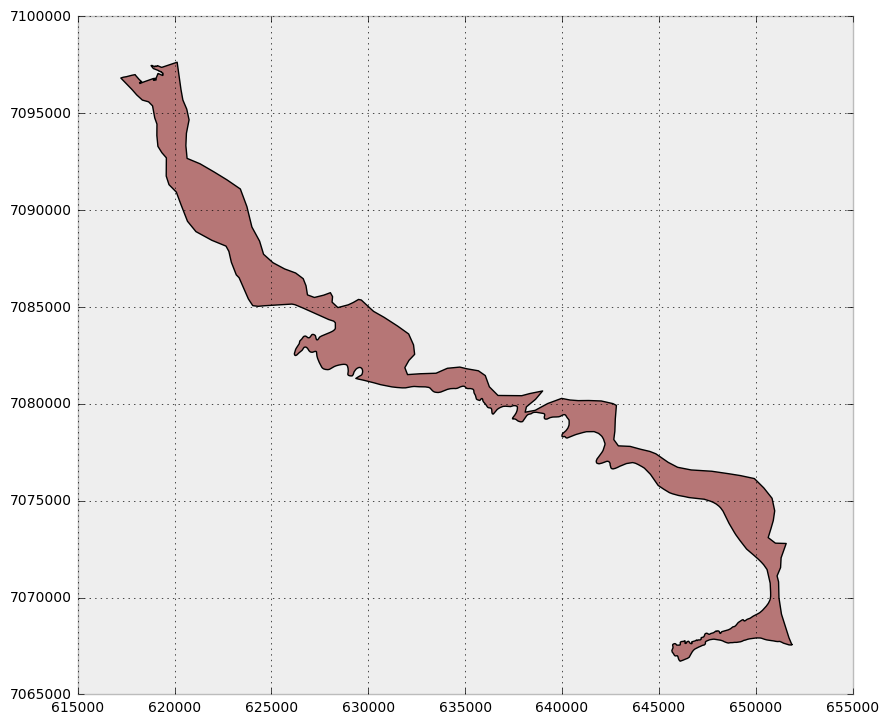

In [24]:
test_union = gdf_waters.loc[ slice_gdf, : ]["geometry"].unary_union
test_union#.plot()

gdf_waters_test_union.loc[ slice_gdf, : ]["geometry"] = test_union
gdf_waters_test_union.plot()

gdf_waters_test_union

In [22]:
# check crs
gdf_waters.crs

{u'ellps': u'GRS80',
 u'lat_0': 46.5,
 u'lat_1': 49,
 u'lat_2': 44,
 u'lon_0': 3,
 u'no_defs': True,
 u'proj': u'lcc',
 u'units': u'm',
 u'x_0': 700000,
 u'y_0': 6600000}

In [25]:
print gdf_waters.crs

{u'lon_0': 3, u'ellps': u'GRS80', u'y_0': 6600000, u'no_defs': True, u'proj': u'lcc', u'x_0': 700000, u'units': u'm', u'lat_2': 44, u'lat_1': 49, u'lat_0': 46.5}


In [26]:
gdf_waters.head(50).loc[ idx[:,"AG001"], idx["MasseDEauA":]]


MasseDEauA MasseDEauT NatureEcou  Niveau  \
CdBassinDC CdMasseDEa                                            
A          AG001               N          N          3       2   
           AG001               N          N          3       1   

                                    NomMasseDE PrecSupMas Regroupees  \
CdBassinDC CdMasseDEa                                                  
A          AG001       Craie de lâAudomarois          1          N   
           AG001       Craie de lâAudomarois          1          N   

                      StMasseDEa  SurfaceAff  SurfaceSsC  SurfaceTot  \
CdBassinDC CdMasseDEa                                                  
A          AG001         ValidÃ©       868.2        82.4       950.6   
           AG001         ValidÃ©       868.2        82.4       950.6   

                      SystemeRef TypeMasseD  \
CdBassinDC CdMasseDEa                         
A          AG001              26         DS   
           AG001              26         DS   

                                                                geometry  \
CdBassinDC CdMasseDEa                                                      
A          AG001       POLYGON ((651859.6700888127 7067573.305585384,...   
           AG001       (POLYGON ((617227.0852775276 7096815.711801797...   

                               area  
CdBassinDC CdMasseDEa                
A          AG001       8.237526e+07  
           AG001       8.681770e+08

In [27]:
def colToDate(df, list_col_names):
    # change to date format
    
    for col in list_col_names :
        df.loc[:, col] = pd.to_datetime( df.loc[:, col], infer_datetime_format=True)
    
    return df

# change date format
gdf_waters = colToDate( gdf_waters, ["DateCreati", "DateMajMas"] )

checkDTypes (gdf_waters) 


---- index :  CdBassinDC
---- index :  CdMasseDEa
---- dtypes col :  CdEcoregio / object
---- dtypes col :  CdEuMasseD / object
---- dtypes col :  CdPolygMas / object
---- dtypes col :  Commentair / object
---- dtypes col :  DateCreati / datetime64[ns]
---- dtypes col :  DateMajMas / datetime64[ns]
---- dtypes col :  FrangeLitt / object
---- dtypes col :  Karstique / object
---- dtypes col :  LatMasseDE / float64
---- dtypes col :  LonMasseDE / float64
---- dtypes col :  MasseDEauA / object
---- dtypes col :  MasseDEauT / object
---- dtypes col :  NatureEcou / object
---- dtypes col :  Niveau / int64
---- dtypes col :  NomMasseDE / object
---- dtypes col :  PrecSupMas / object
---- dtypes col :  Regroupees / object
---- dtypes col :  StMasseDEa / object
---- dtypes col :  SurfaceAff / float64
---- dtypes col :  SurfaceSsC / float64
---- dtypes col :  SurfaceTot / float64
---- dtypes col :  SystemeRef / object
---- dtypes col :  TypeMasseD / object
---- dtypes col :  geometry / object
-

In [28]:
gdf_waters.head()


CdEcoregio CdEuMasseD CdPolygMas Commentair DateCreati  \
CdBassinDC CdMasseDEa                                                          
A          AG001              13    FRAG001   00000002       None 2004-12-31   
           AG001              13    FRAG001   00000001       None 2004-12-31   
           AG002              13    FRAG002   00000003       None 2004-12-31   
           AG003              13    FRAG003   00000005       None 2004-12-31   
           AG003              13    FRAG003   00000004       None 2004-12-31   

                      DateMajMas FrangeLitt Karstique    LatMasseDE  \
CdBassinDC CdMasseDEa                                                 
A          AG001      2013-12-18          N         N  7.069081e+06   
           AG001      2013-12-18          N         N  7.069081e+06   
           AG002      2013-12-18          N         Y  7.072421e+06   
           AG003      2013-12-18          N         N  7.038903e+06   
           AG003      2013-12-18          N         N  7.038903e+06   

                          LonMasseDE      ...      PrecSupMas Regroupees  \
CdBassinDC CdMasseDEa                     ...                              
A          AG001       639573.042158      ...               1          N   
           AG001       639573.042158      ...               1          N   
           AG002       609585.385827      ...               2          Y   
           AG003       685405.450775      ...               1          N   
           AG003       685405.450775      ...               1          N   

                      StMasseDEa  SurfaceAff SurfaceSsC SurfaceTot SystemeRef  \
CdBassinDC CdMasseDEa                                                           
A          AG001         ValidÃ©       868.2       82.4      950.6         26   
           AG001         ValidÃ©       868.2       82.4      950.6         26   
           AG002         ValidÃ©       477.4        0.0      477.4         26   
           AG003         ValidÃ©       742.4      587.5     1329.9         26   
           AG003         ValidÃ©       742.4      587.5     1329.9         26   

                      TypeMasseD  \
CdBassinDC CdMasseDEa              
A          AG001              DS   
           AG001              DS   
           AG002              DS   
           AG003              DS   
           AG003              DS   

                                                                geometry  \
CdBassinDC CdMasseDEa                                                      
A          AG001       POLYGON ((651859.6700888127 7067573.305585384,...   
           AG001       (POLYGON ((617227.0852775276 7096815.711801797...   
           AG002       POLYGON ((617970.4125330001 7063544.312811732,...   
           AG003       (POLYGON ((719164.1102770045 7051492.354207844...   
           AG003       POLYGON ((704207.8221555278 7065745.600930788,...   

                               area  
CdBassinDC CdMasseDEa                
A          AG001       8.237526e+07  
           AG001       8.681770e+08  
           AG002       4.774317e+08  
           AG003       5.875281e+08  
           AG003       7.423879e+08  

[5 rows x 25 columns]

In [30]:
#for pg in gdf_waters.loc["H","HG210"]["geometry"]:
#    print pg


In [31]:
gdf_waters.info(memory_usage="deep")

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 1103 entries, (A, AG001) to (H, HG508)
Data columns (total 25 columns):
CdEcoregio    1103 non-null object
CdEuMasseD    1103 non-null object
CdPolygMas    1103 non-null object
Commentair    551 non-null object
DateCreati    1103 non-null datetime64[ns]
DateMajMas    1103 non-null datetime64[ns]
FrangeLitt    1103 non-null object
Karstique     1103 non-null object
LatMasseDE    1103 non-null float64
LonMasseDE    1103 non-null float64
MasseDEauA    1103 non-null object
MasseDEauT    1103 non-null object
NatureEcou    1103 non-null object
Niveau        1103 non-null int64
NomMasseDE    1103 non-null object
PrecSupMas    1103 non-null object
Regroupees    1103 non-null object
StMasseDEa    1103 non-null object
SurfaceAff    1103 non-null float64
SurfaceSsC    1103 non-null float64
SurfaceTot    1103 non-null float64
SystemeRef    1103 non-null object
TypeMasseD    1103 non-null object
geometry      1103 non-null object
area       

In [32]:

#############################################
### REDUCE SIZE GEOJSON : 3 steps
###    - 1) simplify geoms for all features
###    - 2) union MdE by MdE/CdMasseDEa
###    - 3) convert to TOPOJSON / GEOJSON
#############################################


In [33]:
# copy original gdf 

gdf_waters_reduced = gdf_waters.copy()
#gdf_waters_reduced.head()

In [34]:
### determine tolerance depending on area (linear function y = ax + b)

area_min = gdf_waters["area"].min()
area_max = gdf_waters["area"].max()

tol_min = 5
tol_max = 500

print "area min : ", area_min
print "area max : ", area_max

def linear_tolerance(area):
    a = (tol_max - tol_min) / ( area_max - area_min)
    b = tol_min - ( a * area_min )
    tolerance = ( a * area ) + b
    return tolerance

print linear_tolerance(6000)

area min :  5786.56659817
area max :  53233754762.9
5.00000198463


In [35]:
### SIMPLIFY (1) : simplify geometries by ratio (tolerance)

def simplify_geom(row):
    
    geom = row["geometry"]
    area = row["area"]
    
    ### put a while loop here for test if simplified shape is plottable
    
    geom_simplified = geom.simplify( linear_tolerance(area), preserve_topology=False )
    
    '''
    ## deprecated
    try :
        geom_simplified = geom.simplify( find_tolerance(area), preserve_topology=False )
    except:
        geom_simplified = geom
    '''
    
    return geom_simplified

gdf_waters_reduced["geometry"] = gdf_waters.apply(simplify_geom, axis=1)


In [ ]:
#gdf_waters_reduced.loc[ idx["E":"F"] , ["geometry"] ].plot()


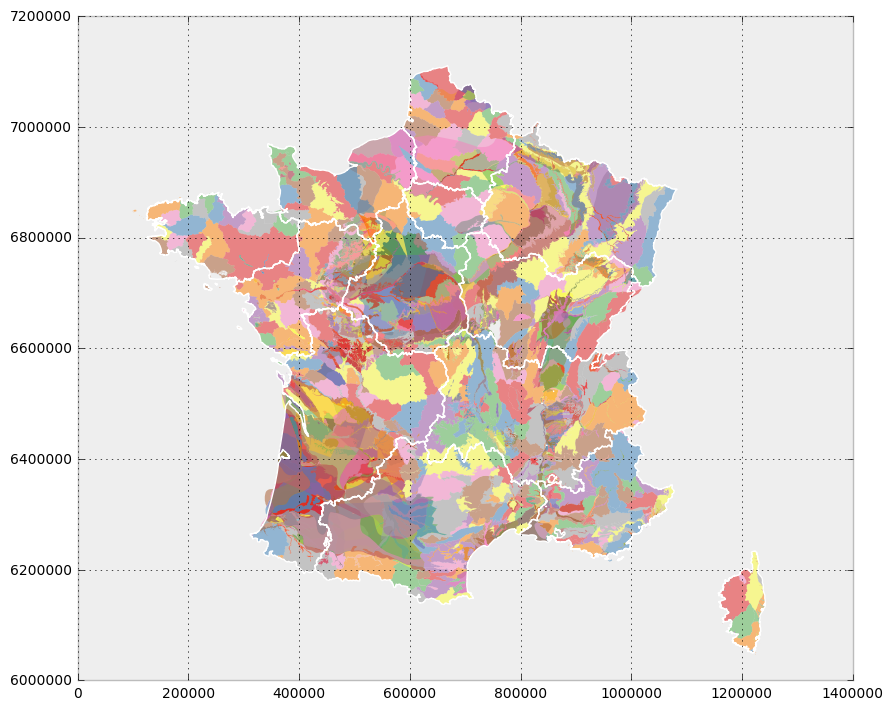

In [46]:
plot_waters = gdf_waters_reduced["geometry"].plot( edgecolor='none') #, linewidth='0.1' )
print "-- plot_waters finished ..."

#plot_dpt = gdf_dpts.plot( ax=waters_plot, cmap=None, alpha=0, edgecolor='White', linewidth='0.1')
plot_water_reg_2015 = gdf_regions_2015.plot( ax=plot_waters, cmap=None, alpha=0, edgecolor='White', linewidth='1')


In [47]:
plot_water_dpt = gdf_dpts.plot( ax=plot_waters, cmap=None, alpha=0, edgecolor='White', linewidth='1')


In [50]:
plot_water_dpt

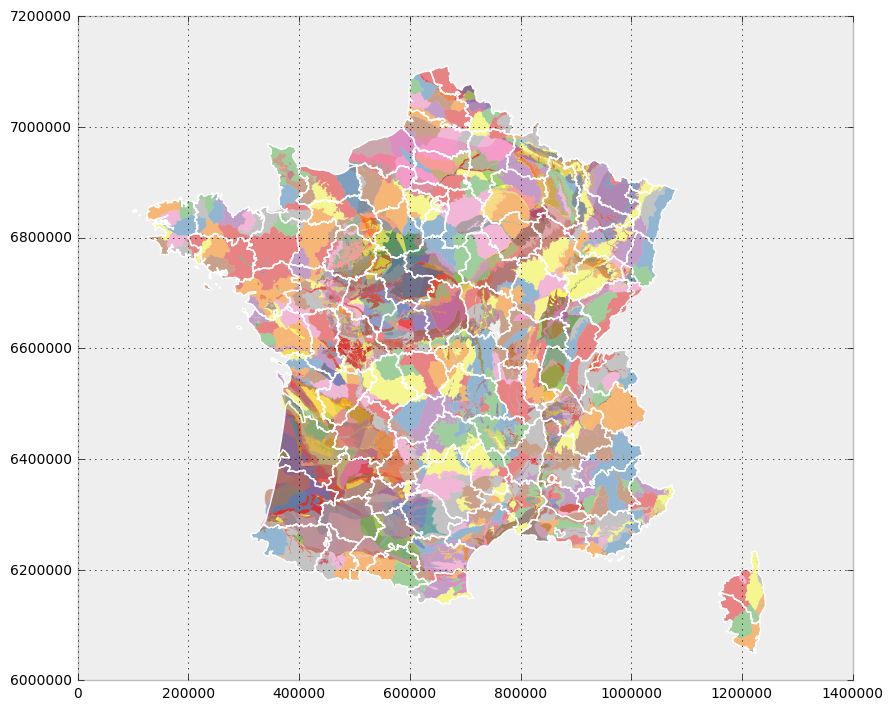

In [48]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
gdf_waters_reduced["geometry"].plot( ax=ax, edgecolor='none')
gdf_dpts.plot( ax=ax, cmap=None, alpha=0, edgecolor='White', linewidth='1')
plt.show()

In [49]:
plt.show()

In [36]:
### determine tolerance depending on area (Bezier curve)
### cf : http://stackoverflow.com/questions/246525/how-can-i-draw-a-bezier-curve-using-pythons-pil 


P1 = (area_min, tol_min)
K1 = (area_max, tol_min)
P2 = (area_max, tol_max)
K2 = (area_min, tol_max)

sequence = [ P1, K1, P2, K2 ]

'''
import mathutils
from mathutils.geometry import interpolate_bezier
import mathutils.Vector as vec

print interpolate_bezier( vec(P1), vec(K1), vec(K2), vec(P2) )



def make_bezier(xys):
    # xys should be a sequence of 2-tuples (Bezier control points)
    n = len(xys)
    
    combinations = pascal_row(n-1)
    ### if only quadratic curve use :
    #combination = (1,3,3,1)
    
    def bezier(ts):
        # This uses the generalized formula for bezier curves
        # http://en.wikipedia.org/wiki/B%C3%A9zier_curve#Generalization
        result = []
        for t in ts:
            tpowers = (t**i for i in range(n))
            upowers = reversed([(1-t)**i for i in range(n)])
            coefs = [c*a*b for c, a, b in zip(combinations, tpowers, upowers)]
            result.append(
                tuple(sum([coef*p for coef, p in zip(coefs, ps)]) for ps in zip(*xys)))
        return result
    return bezier

def pascal_row(n):
    # This returns the nth row of Pascal's Triangle
    result = [1]
    x, numerator = 1, n
    for denominator in range(1, n//2+1):
        # print(numerator,denominator,x)
        x *= numerator
        x /= denominator
        result.append(x)
        numerator -= 1
    if n&1 == 0:
        # n is even
        result.extend(reversed(result[:-1]))
    else:
        result.extend(reversed(result)) 
    return result

print make_bezier(sequence)
'''

"\nimport mathutils\nfrom mathutils.geometry import interpolate_bezier\nimport mathutils.Vector as vec\n\nprint interpolate_bezier( vec(P1), vec(K1), vec(K2), vec(P2) )\n\n\n\ndef make_bezier(xys):\n    # xys should be a sequence of 2-tuples (Bezier control points)\n    n = len(xys)\n    \n    combinations = pascal_row(n-1)\n    ### if only quadratic curve use :\n    #combination = (1,3,3,1)\n    \n    def bezier(ts):\n        # This uses the generalized formula for bezier curves\n        # http://en.wikipedia.org/wiki/B%C3%A9zier_curve#Generalization\n        result = []\n        for t in ts:\n            tpowers = (t**i for i in range(n))\n            upowers = reversed([(1-t)**i for i in range(n)])\n            coefs = [c*a*b for c, a, b in zip(combinations, tpowers, upowers)]\n            result.append(\n                tuple(sum([coef*p for coef, p in zip(coefs, ps)]) for ps in zip(*xys)))\n        return result\n    return bezier\n\ndef pascal_row(n):\n    # This returns the nth 

In [144]:
gdf_waters_reduced.head()


CdEcoregio CdEuMasseD CdPolygMas Commentair DateCreati  \
CdBassinDC CdMasseDEa                                                          
A          AG001              13    FRAG001   00000002       None 2004-12-31   
           AG001              13    FRAG001   00000001       None 2004-12-31   
           AG002              13    FRAG002   00000003       None 2004-12-31   
           AG003              13    FRAG003   00000005       None 2004-12-31   
           AG003              13    FRAG003   00000004       None 2004-12-31   

                      DateMajMas FrangeLitt Karstique    LatMasseDE  \
CdBassinDC CdMasseDEa                                                 
A          AG001      2013-12-18          N         N  7.069081e+06   
           AG001      2013-12-18          N         N  7.069081e+06   
           AG002      2013-12-18          N         Y  7.072421e+06   
           AG003      2013-12-18          N         N  7.038903e+06   
           AG003      2013-12-18          N         N  7.038903e+06   

                          LonMasseDE  \
CdBassinDC CdMasseDEa                  
A          AG001       639573.042158   
           AG001       639573.042158   
           AG002       609585.385827   
           AG003       685405.450775   
           AG003       685405.450775   

                                             ...                          \
CdBassinDC CdMasseDEa                        ...                           
A          AG001                             ...                           
           AG001                             ...                           
           AG002                             ...                           
           AG003                             ...                           
           AG003                             ...                           

                                             NomMasseDE PrecSupMas Regroupees  \
CdBassinDC CdMasseDEa                                                           
A          AG001                Craie de lâAudomarois          1          N   
           AG001                Craie de lâAudomarois          1          N   
           AG002                Calcaires du Boulonnais          2          Y   
           AG003       Craie de la vallÃ©e de la DeÃ»le          1          N   
           AG003       Craie de la vallÃ©e de la DeÃ»le          1          N   

                       StMasseDEa SurfaceAff SurfaceSsC SurfaceTot SystemeRef  \
CdBassinDC CdMasseDEa                                                           
A          AG001          ValidÃ©      868.2       82.4      950.6         26   
           AG001          ValidÃ©      868.2       82.4      950.6         26   
           AG002          ValidÃ©      477.4        0.0      477.4         26   
           AG003          ValidÃ©      742.4      587.5     1329.9         26   
           AG003          ValidÃ©      742.4      587.5     1329.9         26   

                       TypeMasseD  \
CdBassinDC CdMasseDEa               
A          AG001               DS   
           AG001               DS   
           AG002               DS   
           AG003               DS   
           AG003               DS   

                                                                geometry  
CdBassinDC CdMasseDEa                                                     
A          AG001       POLYGON ((651859.6700888127 7067573.305585384,...  
           AG001       (POLYGON ((617227.0852775276 7096815.711801797...  
           AG002       POLYGON ((617970.4125330001 7063544.312811732,...  
           AG003       (POLYGON ((719164.1102770045 7051492.354207844...  
           AG003       POLYGON ((704207.8221555278 7065745.600930788,...  

[5 rows x 24 columns]

In [168]:
gdf_waters_reduced.info(memory_usage="deep")


<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 1103 entries, (A, AG001) to (H, HG508)
Data columns (total 25 columns):
CdEcoregio    1103 non-null object
CdEuMasseD    1103 non-null object
CdPolygMas    1103 non-null object
Commentair    551 non-null object
DateCreati    1103 non-null object
DateMajMas    1103 non-null object
FrangeLitt    1103 non-null object
Karstique     1103 non-null object
LatMasseDE    1103 non-null float64
LonMasseDE    1103 non-null float64
MasseDEauA    1103 non-null object
MasseDEauT    1103 non-null object
NatureEcou    1103 non-null object
Niveau        1103 non-null int64
NomMasseDE    1103 non-null object
PrecSupMas    1103 non-null object
Regroupees    1103 non-null object
StMasseDEa    1103 non-null object
SurfaceAff    1103 non-null float64
SurfaceSsC    1103 non-null float64
SurfaceTot    1103 non-null float64
SystemeRef    1103 non-null object
TypeMasseD    1103 non-null object
geometry      1103 non-null object
area          1103 non-null

In [131]:
#for pg in gdf_waters_reduced.loc[:,"HG210"]["geometry"]:
#    print pg

POLYGON ((681077.108196184 6722325.508935641, 681120.8429548144 6722282.920672491, 681178.1863949448 6722202.494927354, 681217.2994322479 6722139.408087373, 681144.8493295982 6722196.780378807, 681038.3382884562 6722347.623857487, 681077.108196184 6722325.508935641))
MULTIPOLYGON (((681683.8945573717 6721773.287093535, 681673.0468669161 6721731.159062158, 681666.0712795481 6721733.466265365, 681643.4946063906 6721663.207535498, 682061.7142014354 6721146.55115135, 682133.9700357169 6721079.239958912, 682243.3132276163 6720943.914894216, 682286.0422566906 6720878.351639427, 682270.674398914 6720892.720960252, 682248.500087209 6720914.642269995, 682092.2645386234 6721073.596023817, 681604.482670404 6721569.6043729, 681566.7243404984 6721609.893927403, 681546.9080688804 6721633.757395733, 681553.4174134731 6721646.479804564, 681557.2739882693 6721659.437899344, 681561.4084652662 6721683.135892645, 681565.0826201886 6721704.089752939, 681566.8572464511 6721714.567209866, 681556.8104176223 6

In [87]:
### SIMPLIFY (2) : union / geometries for each CdMasseDEa

#original_index   = gdf.index
#original_columns = gdf.columns

### empty geoDataframes for flattened levels
#gdf_bassins_2D = gp.GeoDataFrame(data=None, index=gdf_waters.index , columns=gdf_waters.columns)
gdf_bassins_2D = gp.GeoDataFrame(data=None, index=None , columns=gdf_waters.columns)
#gdf_MdEs_2D    = gp.GeoDataFrame(data=None, index=gdf_waters.index , columns=gdf_waters.columns)
gdf_MdEs_2D    = gp.GeoDataFrame(data=None, index=None , columns=gdf_waters.columns)


### list of unique values MdE_cd for index "CdMasseDEa"
Bassins_cd_dict = {"lev_index" : 1, "cd_list" : list( gdf_waters.index.get_level_values("CdBassinDC").unique() ) }
MdEs_cd_dict    = {"lev_index" : 2, "cd_list" : list( gdf_waters.index.get_level_values("CdMasseDEa").unique() ) }

print Bassins_cd_dict
#print MdEs_cd_dict


def Flatten_nappe(gdf_source, cd_dict, gdf_out):
    
    cd_list = cd_dict["cd_list"]
    level   = cd_dict["lev_index"]
    
    ### loop through MdEs_cd_list to union geometries
    for cd in cd_list :
        
        # set slicer (level of index)
        if level==2 :
            idx_ = idx[ : , cd ]
        elif level == 1 :
            idx_ = idx[ cd, : ]

        # get/copy slice of gdf corresponding to MdE_cd ( for index "CdMasseDEa" )
        cd_gdf = gdf_source.loc[ idx_ , : ].copy()
        
        # only apply union if more than 1 object
        if cd_gdf.shape[0] > 1 :
            
            # union the MdE_geoms if more than 1 row
            cd_geom_union = cd_gdf["geometry"].unary_union

            # create new serie (unique) for simplified MdE / get first row and change geometry
            cd_gdf = cd_gdf.head(1)
            cd_gdf["geometry"] = cd_geom_union

        # add to new geodataframe (listing simplified MdEs + main characteristics)
        gdf_output.loc[ idx_ , :] = cd_gdf
        


{'lev_index': 1, 'cd_list': [u'A', u'B1', u'B2', u'C', u'D', u'E', u'F', u'G', u'H']}


In [88]:
Flatten_nappe(gdf_waters_reduced, Bassins_cd_dict, gdf_bassins_2D )


NameError: name 'gdf_waters_reduced' is not defined

In [ ]:
Flatten_nappe(gdf_waters_reduced, MdEs_cd_dict, gdf_MdEs_2D )


In [81]:
### SIMPLIFY (3) : to topojson


In [18]:
### test read/write /// .shp --> .json

#readSHP(water_shp_fname) ### problem : 1.16 Go file !!!